In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import re
import copy
import seaborn as sns
from itertools import product
sys.path.append("/home/yanhu/DddA/DddA/tdac_seq")
from ddda_dataset import *
from utils import *
from plots import *
import pickle 
from Bio.Seq import Seq
import scipy.stats as ss
%matplotlib inline
mpl.rcParams['pdf.fonttype'] = 42

### Align nanopore sequencing data

In [10]:
# Merge individual nanopre fastq files
fastq_path = "/home/yanhu/data/DddA/HJR244/fastqs"
fastq_libs = os.listdir(fastq_path)
for lib in fastq_libs:
    fastq_dir = os.path.join(fastq_path, lib)
    fastq_files = os.listdir(fastq_dir)
    if not os.path.exists(os.path.join(fastq_path, lib, "merged.fastq.gz")):
        os.system("cat " + fastq_dir + "/PAW*fastq.gz > " + fastq_dir + "/merged.fastq.gz")

In [11]:
# Create a dictionary for reference regions
ref_range_dict = {
    'HJR244': ('chr11', 5279265, 5282582)
}
locus = "HJR244"

for replicate in ["HJR244_1", "HJR244_2"]:

    # If we have already aligned reads before, load the saved ddda_data object
    save_path = "/home/yanhu/data/DddA/HJR244/ddda_data_" + replicate + ".pkl"
    if os.path.exists(save_path):
        with open(save_path, "rb") as f:
            ddda_data = pickle.load(f)
        continue

    # Create folder for saving plots
    plot_dir = "/home/yanhu/data/DddA/HJR244/plots/" + replicate
    if not os.path.exists(plot_dir):
        os.system("mkdir " + plot_dir)
        
    # Initialize ddda_dataset
    ddda_data = ddda_dataset(
        ID = replicate, 
        region_dict = ref_range_dict, 
        genome_file = "/home/yanhu/data/DddA/shared/refGenomes/hg38.fa", 
        fastq_file = "/home/yanhu/data/DddA/HJR244/fastqs/" + replicate + "/merged.fastq.gz", 
        working_dir = "/home/yanhu/data/DddA/HJR244/"
    )
    
    # Load DddA bias model
    with open("/home/yanhu/data/DddA/HJR245/bias_dict.pkl", "rb") as f:
        ddda_data.bias_model = pickle.load(f)
    
    # Align reads
    gap_threshold = 500
    ddda_data.align_reads(
        start_gap_threshold = gap_threshold,
        end_gap_threshold = gap_threshold
    )

    with open(save_path, "wb") as f:
        pickle.dump(ddda_data, f)

### Export data matrices to tsv files

In [2]:
### Export data slots to tsv files
for replicate in ["HJR244_1", "HJR244_2"]:

    # Load previously initialized ddda_dataset objects
    ddda_data_path = "/home/yanhu/data/DddA/HJR244/ddda_data_" + replicate + ".pkl"
    with open(ddda_data_path, "rb") as f:
        ddda_data = pickle.load(f)

    # Export data matrices
    export_to_tsv(
        ddda_data, 
        export_DddA_edit=True, 
        export_del=True, 
        export_ABE_edit=False,
        export_dir="/home/yanhu/data/DddA/HJR244/data_export/")

Exporting DddA edits for dataset HJR244_1 at locus HJR244
Exporting deletions for dataset HJR244_1 at locus HJR244
Exporting aligned reads for dataset HJR244_1 at locus HJR244
Exporting DddA edits for dataset HJR244_2 at locus HJR244
Exporting deletions for dataset HJR244_2 at locus HJR244
Exporting aligned reads for dataset HJR244_2 at locus HJR244


### Find cutting positions of sgRNAs

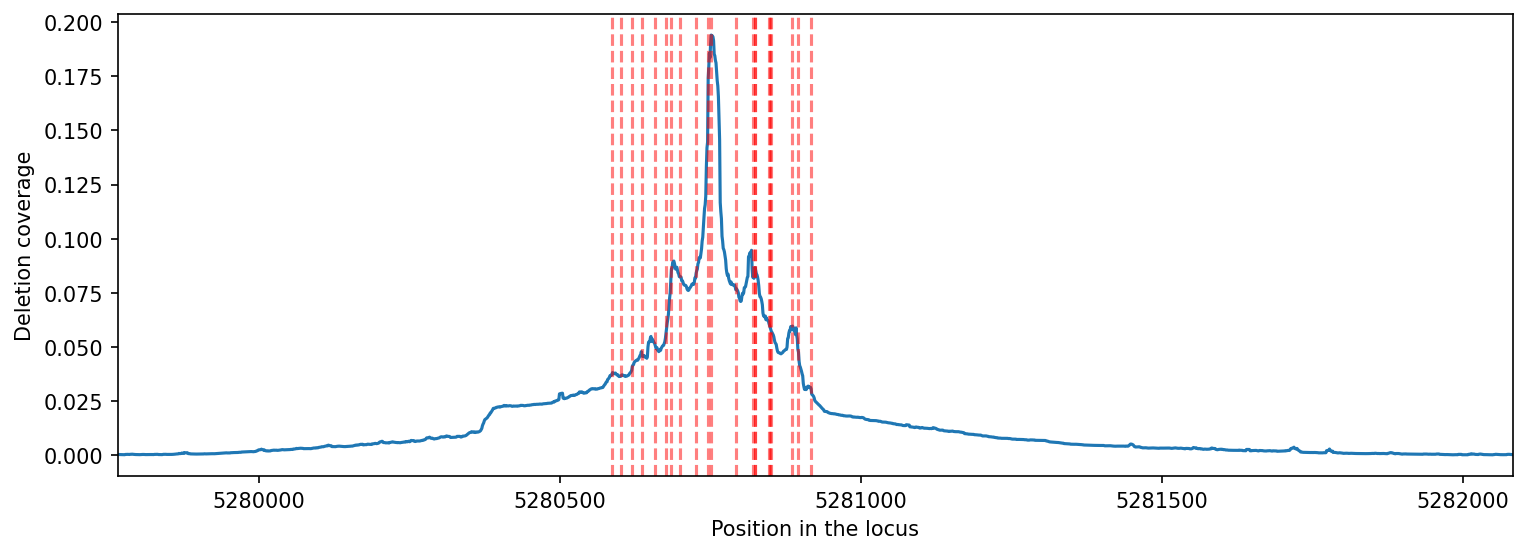

In [65]:
# Load sgRNA sequences
sgRNAs = pd.read_csv("/home/yanhu/data/DddA/HJR244/sgRNA.tsv", sep="\t", header=None)
sgRNAs.columns = ["ID", "sequence"]

# Get sequence of the target locus
ref_seq = ddda_data.ref_seq_dict[locus]

# Find sgRNA positions in the target locus
cut_sites = []
for i, row in sgRNAs.iterrows():
    guide_seq_forward = row["sequence"].upper()
    guide_seq_reverse = str(Seq(guide_seq_forward).reverse_complement())
    forward_match = ref_seq.find(guide_seq_forward)
    reverse_match = ref_seq.find(guide_seq_reverse)
    if forward_match >= 0 and reverse_match == -1:
        cut_site = forward_match + len(guide_seq_forward) - 3 # Cas9 cuts at the 3rd to last base
    elif forward_match == -1 and reverse_match >= 0:
        cut_site = reverse_match + 3
    else:
        raise ValueError("No match for sgRNA found in the target locus")
    cut_sites.append(cut_site)

# Sort sgRNA cut sites by coordinate
cut_sites = sorted(cut_sites)

# Visualize deletion coverage and sgRNA positions
del_matrix = ddda_data.del_dict[locus]
del_coverage = np.array(np.mean(del_matrix, axis=0))[0]
region_start, region_end = ref_range_dict[locus][1], ref_range_dict[locus][2] + 1
plt.figure(dpi=150, figsize=(12, 4))
plt.plot(np.arange(region_start, region_end), del_coverage)
for cut_site in cut_sites:
    plt.axvline(x = cut_site + region_start, color="red", linestyle="dashed", alpha=0.5)
plt.ylabel("Deletion coverage")
plt.xlabel("Position in the locus")
plot_start, plot_end = 5279765, 5282082
plt.xlim([plot_start, plot_end])
plt.ticklabel_format(style='plain', axis='x', scilimits=(0,0))
plt.savefig(os.path.join(plot_dir, "sgRNA_deletion_coverage_" + replicate + "_" + \
                         str(plot_start) + "_" + str(plot_end) + ".pdf"))
plt.show()

### Calculate cutting distribution

In [27]:
cutting_vec = np.zeros(del_matrix.shape[1] - 1)
for read_ind in tqdm(range(del_matrix.shape[0])):
    read_del = np.array(del_matrix[read_ind, :].todense()).squeeze()
    cutting_vec += np.abs(np.diff(read_del))

100%|██████████████████████████████| 2039554/2039554 [02:11<00:00, 15534.77it/s]


In [115]:
# Calculate distance of deletion edges (cut sites) to the nearest sgRNA taget site
sgRNA_dist = []
for i in range(1200, 1800):
    dist = np.min(np.abs(np.array(cut_sites) - i))
    if cutting_vec[i] > 0:
        sgRNA_dist.append(np.ones(int(cutting_vec[i])) * dist)
sgRNA_dist = np.concatenate(sgRNA_dist)

# Also calculate a background distribution
#rand_cut_pos = np.random.randint(low=min(cut_sites), high=max(cut_sites), size=len(sgRNA_dist))
rand_cut_pos = np.random.randint(low=1200, high=1800, size=len(sgRNA_dist))
cut_sites_arr = np.array(cut_sites)
rand_cut_dist = np.array([np.min(np.abs(cut_sites_arr - i)) for i in tqdm(rand_cut_pos)])

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1664532/1664532 [00:07<00:00, 235561.62it/s]


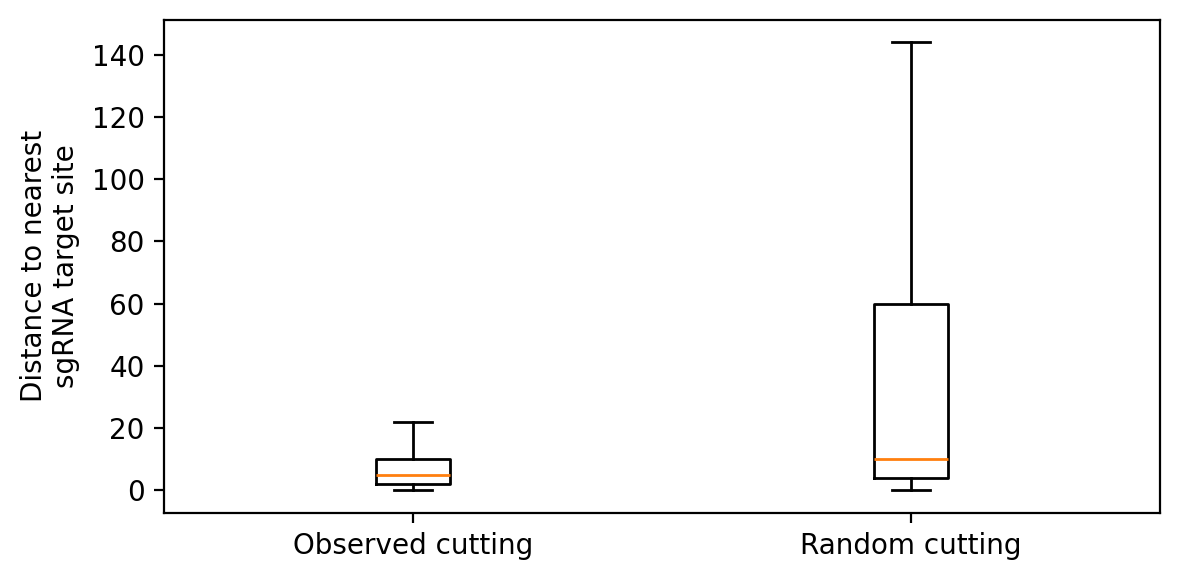

In [116]:
fig, ax = plt.subplots(1, 1, dpi=200, figsize=(6,3))
ax.boxplot(
    [sgRNA_dist, rand_cut_dist],
    sym=""
)
ax.set_xticklabels(['Observed cutting', "Random cutting"])
ax.set_ylabel("Distance to nearest\nsgRNA target site")
plt.savefig(os.path.join(plot_dir, "sgRNA_cutting_to_nearest_sgRNA_distance_distribution.pdf"))
plt.tight_layout()
plt.show()

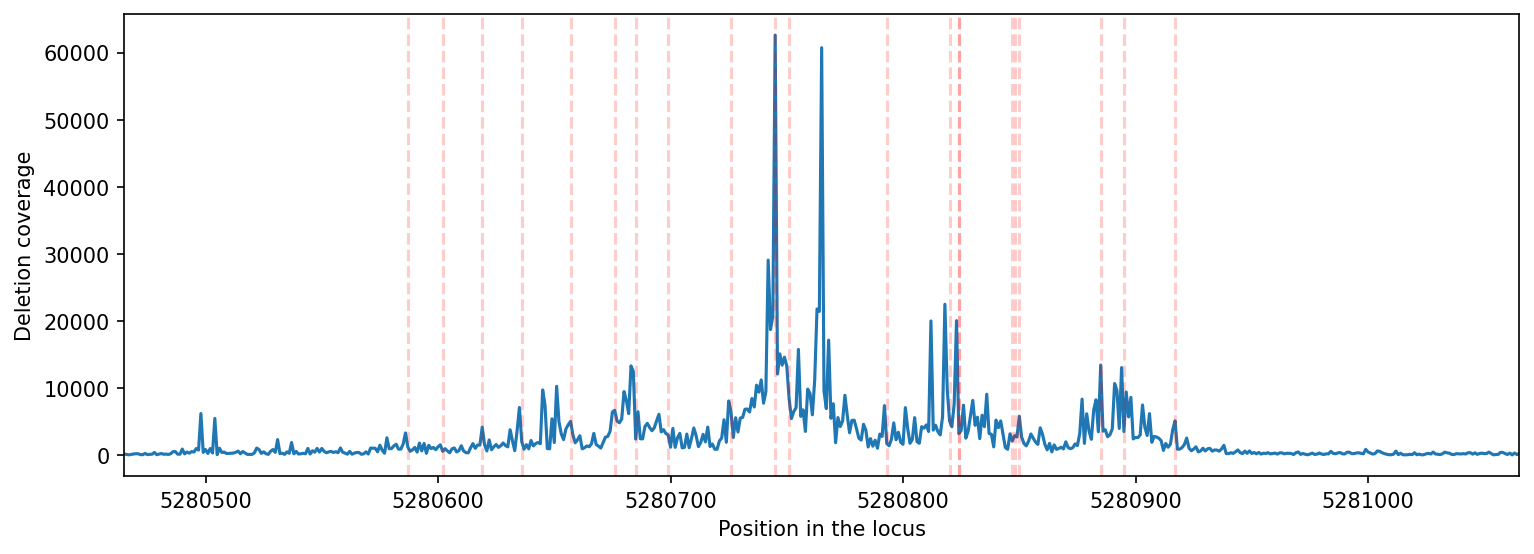

In [111]:
plt.figure(dpi=150, figsize=(12, 4))
region_start, region_end = ref_range_dict[locus][1], ref_range_dict[locus][2]
plt.plot(np.arange(region_start, region_end), cutting_vec)
for cut_site in cut_sites:
    plt.axvline(x = cut_site + region_start, color="red", linestyle="dashed", alpha=0.2)
plt.ylabel("Deletion coverage")
plt.xlabel("Position in the locus")
plt.ticklabel_format(style='plain', axis='x', scilimits=(0,0))
plot_dir = "/home/yanhu/data/DddA/HJR244/plots/" + replicate
plot_start, plot_end = region_start + 1200, region_start + 1800#5280250, 5281250
plt.xlim([plot_start, plot_end])
plt.savefig(os.path.join(plot_dir, "sgRNA_cutting_density_" + replicate + "_" + \
                         str(plot_start) + "_" + str(plot_end) + ".pdf"))
plt.show()

### Calculate impact of CRISPR deletion on DddA edits

In [5]:
sgRNA_results = {}
for replicate in ["HJR244_1", "HJR244_2"]:

    with open("/home/yanhu/data/DddA/HJR244/ddda_data_" + replicate + ".pkl", "rb") as f:
        ddda_data = pickle.load(f)
    
    # Compute a read-by-position matrix of deletion labels
    del_matrix = ddda_data.del_dict[locus]

    # Get strandedness of each read
    strands = ddda_data.read_strands[locus]
    strand_read_inds = {
        "C_to_T" : np.where(strands == 0)[0],
        "G_to_A" : np.where(strands == 1)[0]
    }

    sgRNA_results[replicate] = {}

    for sgRNA_ind in range(len(cut_sites)):

        print("Processing sgRNA ", sgRNA_ind)

        ###############################################################
        # Select reads with and without deletion by the current sgRNA #
        ###############################################################
    
        # Find reads where the sgRNA target site is covered by a deletion
        del_start, del_end = cut_sites[sgRNA_ind] - 20, cut_sites[sgRNA_ind] + 20
        target_site_del = np.squeeze(np.array(np.max(del_matrix[:, del_start:del_end], axis=1).todense()))
        del_read_inds = np.where(target_site_del == 1)[0]
        
        # Only keep reads where positions outside of the vicinity of the sgRNA target site are not deleted
        upstream_filter = np.squeeze(np.array(np.max(del_matrix[:, :del_start], axis=1).todense())) == 0
        downstream_filter = np.squeeze(np.array(np.max(del_matrix[:,del_end:], axis=1).todense())) == 0
        filter = np.where(upstream_filter & downstream_filter)[0]
        del_read_inds = np.intersect1d(del_read_inds, filter)
        
        # Separately, also find reads without any deletion as a control
        read_with_del = np.squeeze(np.array(np.max(del_matrix, axis=1).todense()))
        undel_read_inds = np.where(read_with_del == 0)[0]

        ###################################
        # Down-sampling and deduplication #
        ###################################
        
        # Down-sample the number of reads
        min_num = min(len(del_read_inds), len(undel_read_inds), 5000)
        del_read_inds = np.random.choice(del_read_inds, min_num, replace=False)
        undel_read_inds = np.random.choice(undel_read_inds, min_num, replace=False)

        # De-duplicate reads
        del_read_ids = ddda_data.dedup_reads(
            locus = locus, 
            read_ids = np.array(ddda_data.read_ids[locus])[del_read_inds]
        )
        undel_read_ids = ddda_data.dedup_reads(
            locus = locus, 
            read_ids = np.array(ddda_data.read_ids[locus])[undel_read_inds]
        )

        # For each read ID, get its index in the full read ID list
        locus_ids = ddda_data.read_ids[locus]
        locus_id_dict = dict(zip(locus_ids, np.arange(len(locus_ids))))
        del_read_inds = np.array([*map(locus_id_dict.get, del_read_ids)])
        undel_read_inds = np.array([*map(locus_id_dict.get, undel_read_ids)])

        ###############################################################
        # Calculate DddA editing rate for deleted and undeleted reads #
        ###############################################################

        sgRNA_results[replicate][sgRNA_ind] = {}
        for strand in  ["C_to_T", "G_to_A"]:

            # Calculate average editing rate on deleted reads for both C-to-T and G-to-A strands
            del_read_inds_stranded = np.intersect1d(del_read_inds, strand_read_inds[strand])
            del_edits = np.array(np.mean(ddda_data.edit_dict[locus][del_read_inds_stranded, :], axis=0))[0, :]
    
            # Calculate average editing rate on undeleted reads for both C-to-T and G-to-A strands
            undel_read_inds_stranded = np.intersect1d(undel_read_inds, strand_read_inds[strand])
            undel_edits = np.array(np.mean(ddda_data.edit_dict[locus][undel_read_inds_stranded, :], axis=0))[0, :]
    
            # Mask edits in the deleted region
            del_edits[del_start:del_end] = 0
            undel_edits[del_start:del_end] = 0
    
            strand_results = {
                "del_read_inds" : del_read_inds_stranded,
                "undel_read_inds" : undel_read_inds_stranded,
                "n_reads" : min_num,
                "del_edits" : del_edits,
                "undel_edits" : undel_edits
            }
    
            sgRNA_results[replicate][sgRNA_ind][strand] = strand_results

with open("/home/yanhu/data/DddA/HJR244/sgRNA_results.pkl", "wb") as f:
    pickle.dump(sgRNA_results, f)

Processing sgRNA  0


100%|████████████████████████████████████████████████████████████████████| 3986/3986 [00:00<00:00, 7176.06it/s]
3986it [00:00, 847621.97it/s]
100%|████████████████████████████████████████████████████████████████████| 3986/3986 [00:00<00:00, 8177.41it/s]
3986it [00:00, 530847.01it/s]


Processing sgRNA  1


100%|████████████████████████████████████████████████████████████████████| 2418/2418 [00:00<00:00, 6777.17it/s]
2418it [00:00, 557917.65it/s]
100%|████████████████████████████████████████████████████████████████████| 2418/2418 [00:00<00:00, 6977.51it/s]
2418it [00:00, 677295.78it/s]


Processing sgRNA  2


100%|████████████████████████████████████████████████████████████████████| 4979/4979 [00:00<00:00, 7208.92it/s]
4979it [00:00, 476290.64it/s]
100%|████████████████████████████████████████████████████████████████████| 4979/4979 [00:00<00:00, 7155.82it/s]
4979it [00:00, 617305.34it/s]


Processing sgRNA  3


100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 7153.46it/s]
5000it [00:00, 621415.19it/s]
100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 7157.16it/s]
5000it [00:00, 595088.68it/s]


Processing sgRNA  4


100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 7037.71it/s]
5000it [00:00, 941102.14it/s]
100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8076.30it/s]
5000it [00:00, 1145483.94it/s]


Processing sgRNA  5


100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8187.23it/s]
5000it [00:00, 574546.45it/s]
100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8148.36it/s]
5000it [00:00, 734966.01it/s]


Processing sgRNA  6


100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8273.99it/s]
5000it [00:00, 1230939.72it/s]
100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8217.17it/s]
5000it [00:00, 720472.72it/s]


Processing sgRNA  7


100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8280.46it/s]
5000it [00:00, 1220907.03it/s]
100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8360.20it/s]
5000it [00:00, 1137530.92it/s]


Processing sgRNA  8


100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8197.72it/s]
5000it [00:00, 1206716.15it/s]
100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8248.52it/s]
5000it [00:00, 750456.97it/s]


Processing sgRNA  9


100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8196.91it/s]
5000it [00:00, 1181161.36it/s]
100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8110.00it/s]
5000it [00:00, 744383.63it/s]


Processing sgRNA  10


100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8121.88it/s]
5000it [00:00, 1152724.67it/s]
100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8110.52it/s]
5000it [00:00, 1173691.52it/s]


Processing sgRNA  11


100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8168.41it/s]
5000it [00:00, 1111603.94it/s]
100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8133.81it/s]
5000it [00:00, 1161857.06it/s]


Processing sgRNA  12


100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8115.48it/s]
5000it [00:00, 1200018.31it/s]
100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8133.51it/s]
5000it [00:00, 1080226.64it/s]


Processing sgRNA  13


100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8147.93it/s]
5000it [00:00, 1166250.70it/s]
100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8115.12it/s]
5000it [00:00, 1178970.09it/s]


Processing sgRNA  14


100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8053.11it/s]
5000it [00:00, 1125323.03it/s]
100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8089.58it/s]
5000it [00:00, 1163597.63it/s]


Processing sgRNA  15


100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 7994.98it/s]
5000it [00:00, 1146235.24it/s]
100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8093.55it/s]
5000it [00:00, 1118063.66it/s]


Processing sgRNA  16


100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8086.30it/s]
5000it [00:00, 1197209.57it/s]
100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8059.19it/s]
5000it [00:00, 1145233.73it/s]


Processing sgRNA  17


100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8088.64it/s]
5000it [00:00, 1086269.55it/s]
100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8161.73it/s]
5000it [00:00, 751290.39it/s]


Processing sgRNA  18


100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8122.35it/s]
5000it [00:00, 1170220.41it/s]
100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8088.37it/s]
5000it [00:00, 1133779.53it/s]


Processing sgRNA  19


100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8043.88it/s]
5000it [00:00, 1199606.45it/s]
100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8089.35it/s]
5000it [00:00, 1198989.19it/s]


Processing sgRNA  20


100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8078.79it/s]
5000it [00:00, 1117408.35it/s]
100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8107.74it/s]
5000it [00:00, 756985.27it/s]


Processing sgRNA  0


100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8115.27it/s]
5000it [00:00, 1084696.39it/s]
100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8109.57it/s]
5000it [00:00, 1117706.12it/s]


Processing sgRNA  1


100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8148.25it/s]
5000it [00:00, 1233546.26it/s]
100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8148.89it/s]
5000it [00:00, 1162501.11it/s]


Processing sgRNA  2


100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8192.83it/s]
5000it [00:00, 915786.90it/s]
100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8164.78it/s]
5000it [00:00, 880010.07it/s]


Processing sgRNA  3


100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8110.87it/s]
5000it [00:00, 1184497.03it/s]
100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8143.46it/s]
5000it [00:00, 1175995.07it/s]


Processing sgRNA  4


100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8105.60it/s]
5000it [00:00, 1170220.41it/s]
100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 7830.18it/s]
5000it [00:00, 1172903.80it/s]


Processing sgRNA  5


100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8067.22it/s]
5000it [00:00, 1097812.91it/s]
100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8055.00it/s]
5000it [00:00, 1117944.45it/s]


Processing sgRNA  6


100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8126.03it/s]
5000it [00:00, 1164760.90it/s]
100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8014.70it/s]
5000it [00:00, 1145671.67it/s]


Processing sgRNA  7


100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8064.91it/s]
5000it [00:00, 1154374.42it/s]
100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8123.45it/s]
5000it [00:00, 1157177.07it/s]


Processing sgRNA  8


100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8164.52it/s]
5000it [00:00, 1177579.88it/s]
100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8190.85it/s]
5000it [00:00, 1110191.64it/s]


Processing sgRNA  9


100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8140.49it/s]
5000it [00:00, 1128654.00it/s]
100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8108.85it/s]
5000it [00:00, 1131027.94it/s]


Processing sgRNA  10


100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8197.39it/s]
5000it [00:00, 1103938.52it/s]
100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8161.81it/s]
5000it [00:00, 1111898.63it/s]


Processing sgRNA  11


100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8058.94it/s]
5000it [00:00, 908447.91it/s]
100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8084.69it/s]
5000it [00:00, 1099251.49it/s]


Processing sgRNA  12


100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 7974.99it/s]
5000it [00:00, 1171855.16it/s]
100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8180.12it/s]
5000it [00:00, 1133718.24it/s]


Processing sgRNA  13


100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8232.92it/s]
5000it [00:00, 1091357.20it/s]
100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8112.78it/s]
5000it [00:00, 1162372.24it/s]


Processing sgRNA  14


100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8087.00it/s]
5000it [00:00, 1166704.87it/s]
100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8082.28it/s]
5000it [00:00, 1096550.07it/s]


Processing sgRNA  15


100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8142.22it/s]
5000it [00:00, 1192512.23it/s]
100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8215.07it/s]
5000it [00:00, 1172117.15it/s]


Processing sgRNA  16


100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8180.41it/s]
5000it [00:00, 1145546.51it/s]
100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8069.41it/s]
5000it [00:00, 1160571.11it/s]


Processing sgRNA  17


100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8133.52it/s]
5000it [00:00, 1207132.91it/s]
100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8048.70it/s]
5000it [00:00, 1045179.17it/s]


Processing sgRNA  18


100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8121.16it/s]
5000it [00:00, 704073.05it/s]
100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8175.41it/s]
5000it [00:00, 1121171.88it/s]


Processing sgRNA  19


100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8181.33it/s]
5000it [00:00, 1145483.94it/s]
100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8084.30it/s]
5000it [00:00, 1099885.67it/s]


Processing sgRNA  20


100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8158.52it/s]
5000it [00:00, 1217080.84it/s]
100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8137.90it/s]
5000it [00:00, 1176786.94it/s]


In [4]:
with open("/home/yanhu/data/DddA/HJR244/sgRNA_results.pkl", "rb") as f:
    sgRNA_results = pickle.load(f)

### Compare results across sgRNAs and replicates

In [5]:
sgRNA_effect = {}
read_count = {}
for replicate in ["HJR244_1", "HJR244_2"]:
    effect_mtx = []
    for sgRNA_ind in range(len(cut_sites)):

        # Calculate effect of sgRNA on DddA edits
        CT_del_edits = sgRNA_results[replicate][sgRNA_ind]["C_to_T"]["del_edits"]
        CT_undel_edits = sgRNA_results[replicate][sgRNA_ind]["C_to_T"]["undel_edits"]
        GA_del_edits = sgRNA_results[replicate][sgRNA_ind]["G_to_A"]["del_edits"]
        GA_undel_edits = sgRNA_results[replicate][sgRNA_ind]["G_to_A"]["undel_edits"]
        diff_edits = (CT_del_edits - CT_undel_edits + GA_del_edits - GA_undel_edits) / 2

        # Smoothing while masking deleted regions
        mask = np.zeros(len(diff_edits))
        mask[max(0, cut_sites[sgRNA_ind] - 20):min(cut_sites[sgRNA_ind] + 20, len(mask))] = 1
        diff_edits = masked_smooth(x=diff_edits, mask=mask, radius=50)
        #diff_edits = np.convolve(diff_edits, np.ones(100), mode="same") / 100
        effect_mtx.append(diff_edits)

        # Also record read depth for the current sgRNA (save the smaller value between the replicates)
        n_reads = sgRNA_results[replicate][sgRNA_ind]["C_to_T"]["n_reads"] + \
            sgRNA_results[replicate][sgRNA_ind]["G_to_A"]["n_reads"]
        if sgRNA_ind not in read_count:
            read_count[sgRNA_ind] = n_reads
        else:
            read_count[sgRNA_ind] = min(read_count[sgRNA_ind], n_reads)
    sgRNA_effect[replicate] = np.array(effect_mtx)

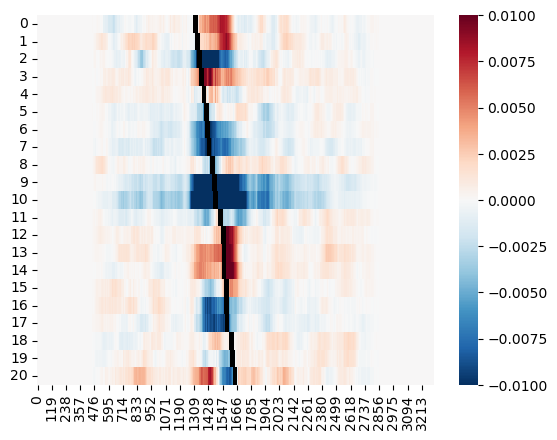

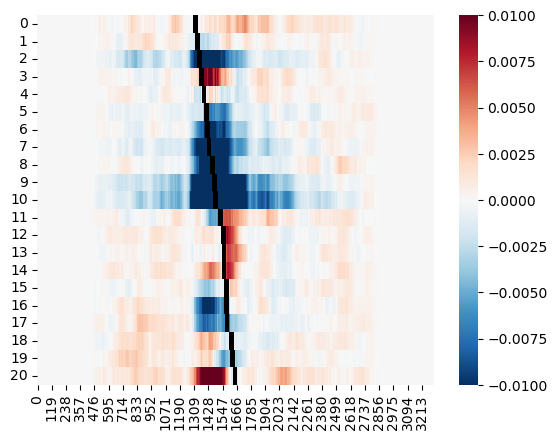

In [8]:
for replicate in ["HJR244_1", "HJR244_2"]:
    plot_dir = "/home/yanhu/data/DddA/HJR244/plots/" + replicate
    del_mask = []
    locus_len = del_matrix.shape[1]
    for cut_site in np.array(cut_sites):
        del_vec = np.zeros(locus_len)
        del_vec[max(0, cut_site - 20):min(cut_site + 20, locus_len)] = 1
        del_mask.append(del_vec)
    del_mask = np.array(del_mask) > 0
    import matplotlib as mpl
    cmap = mpl.colormaps.get_cmap('RdBu_r')
    cmap.set_bad("k")
    ax = sns.heatmap(sgRNA_effect[replicate], cmap=cmap, vmax=0.01, vmin=-0.01, mask=del_mask)
    ax.collections[0].set_rasterized(True)
    plt.savefig(os.path.join(plot_dir, "sgRNA_diff_edit_heatmap_" + replicate + ".pdf"))
    plt.show()

In [9]:
# Calculate correlation between replicates for each sgRNA
replicate_cor = []
for sgRNA_ind in range(len(cut_sites)):
    replicate_cor.append(ss.pearsonr(
        sgRNA_effect["HJR244_1"][sgRNA_ind, :],
        sgRNA_effect["HJR244_2"][sgRNA_ind, :]
    ).statistic)

# Calculate overall impact for each sgRNA
impact_score = []
for sgRNA_ind in range(len(cut_sites)):
    score_1 = np.sqrt(np.sum(np.power(sgRNA_effect["HJR244_1"][sgRNA_ind, :], 2)))
    score_2 = np.sqrt(np.sum(np.power(sgRNA_effect["HJR244_2"][sgRNA_ind, :], 2)))
    impact_score.append(min(score_1, score_2))

100%|████████████████████████████████████████████████████████████████████| 3478/3478 [00:02<00:00, 1411.68it/s]


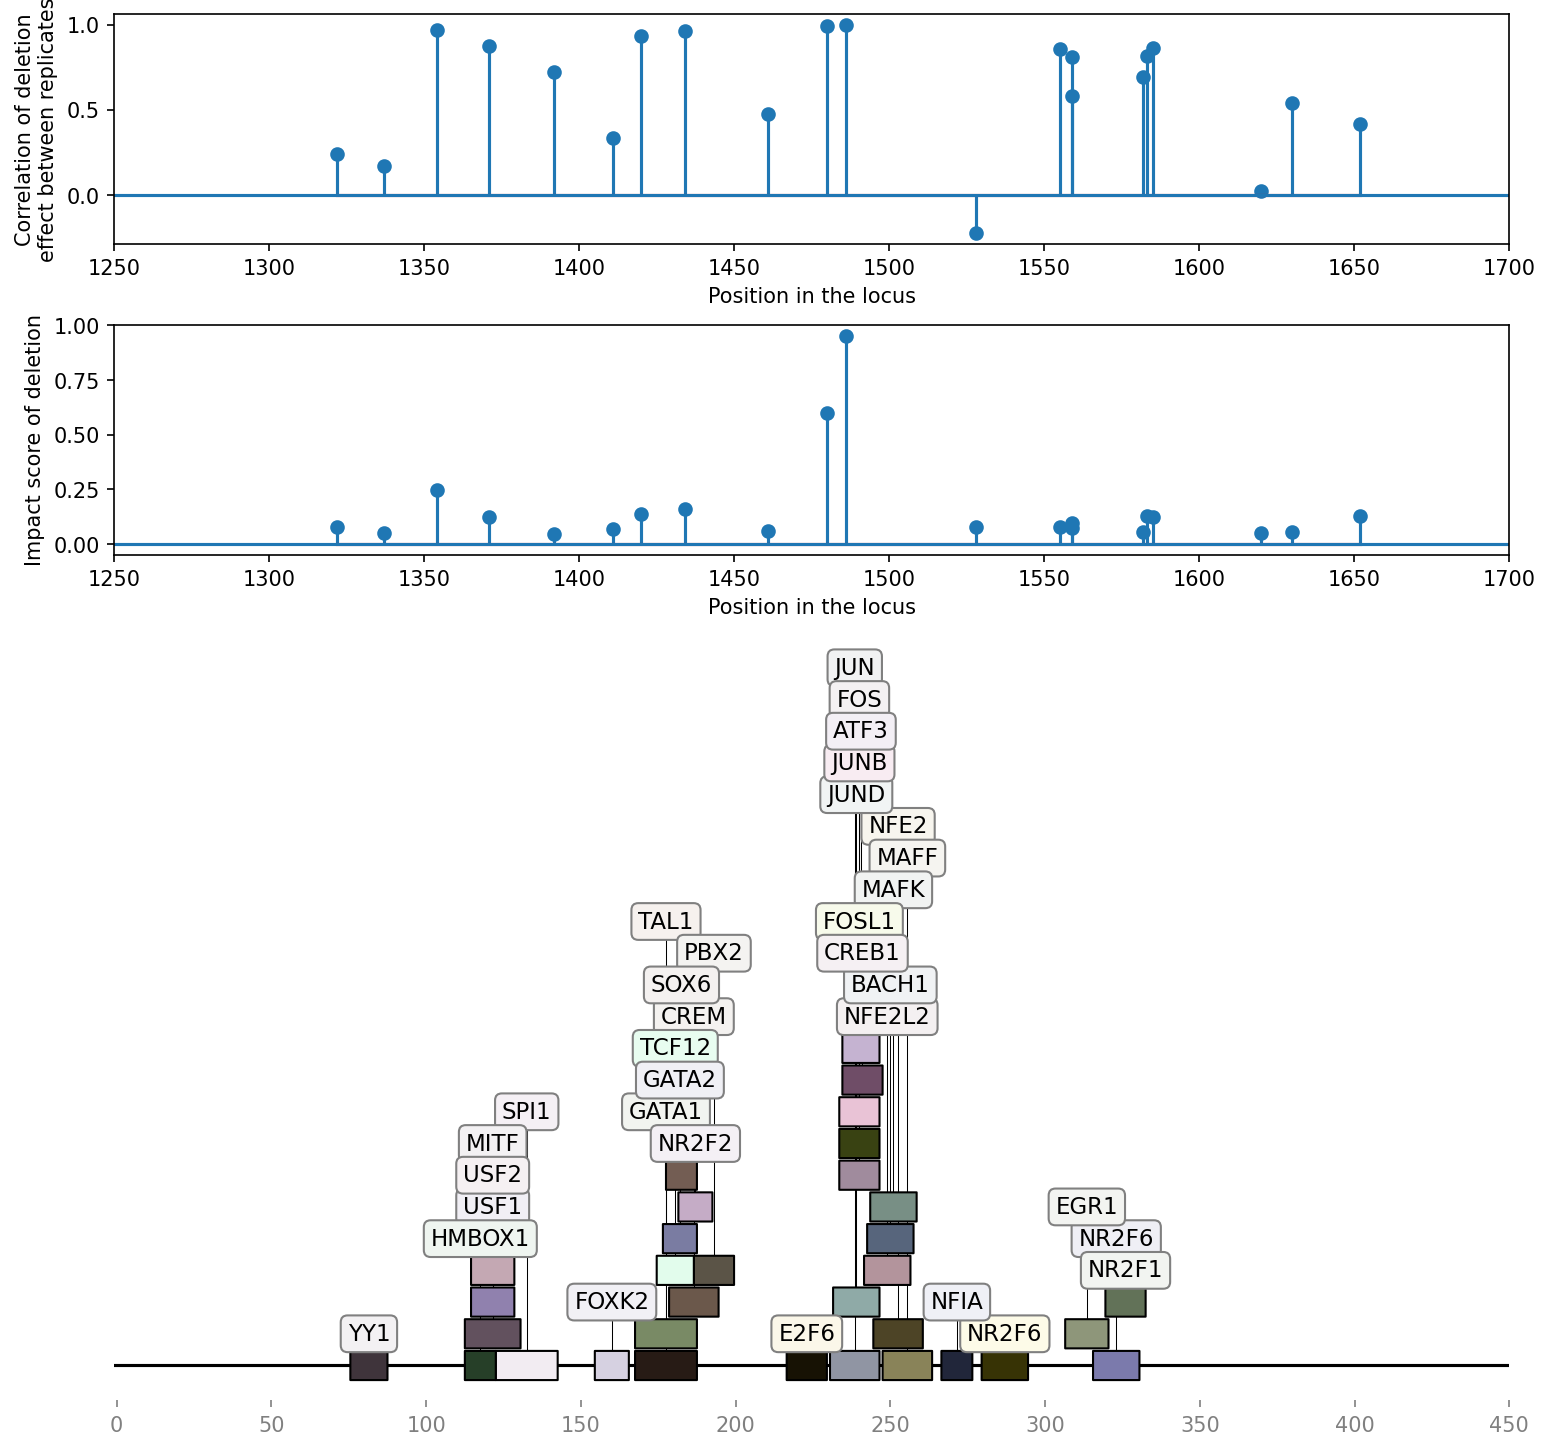

In [21]:
# Load Unibind TF binding sites
unibind_dir = "/home/yanhu/data/PRINT/multiScaleFootprinting/data/shared/unibind/damo_hg38_all_TFBS"
TF_sites = load_unibind_sites(unibind_dir)

# Find TF motifs in the current plotted region
plot_start, plot_end = 1250, 1700
region_chr, region_start, region_end = ref_range_dict[locus]
region_plot_start = region_start + plot_start
region_plot_end = region_start + plot_end

plot_dir = "/home/yanhu/data/DddA/HJR244/plots/sgRNA_diff_edit_reproducibility"
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
    
fig, ax = plt.subplots(3, 1, dpi=150, figsize=(12, 12), gridspec_kw={'height_ratios': [1.5, 1.5, 5]})

ax[0].stem(cut_sites, replicate_cor) 
ax[0].set_ylabel("Correlation of deletion\neffect between replicates")
ax[0].set_xlabel("Position in the locus")
ax[0].set_xlim([plot_start, plot_end])
ax[0].axhline(y=0)

ax[1].stem(cut_sites, impact_score) 
ax[1].set_ylabel("Impact score of deletion")
ax[1].set_xlabel("Position in the locus")
ax[1].set_xlim([plot_start, plot_end])
ax[1].axhline(y=0)

plot_TF_track(TF_sites, region_chr, region_plot_start, region_plot_end, ax[2])

plt.savefig(os.path.join(plot_dir, "sgRNA_diff_edit_reproducibility.pdf"))

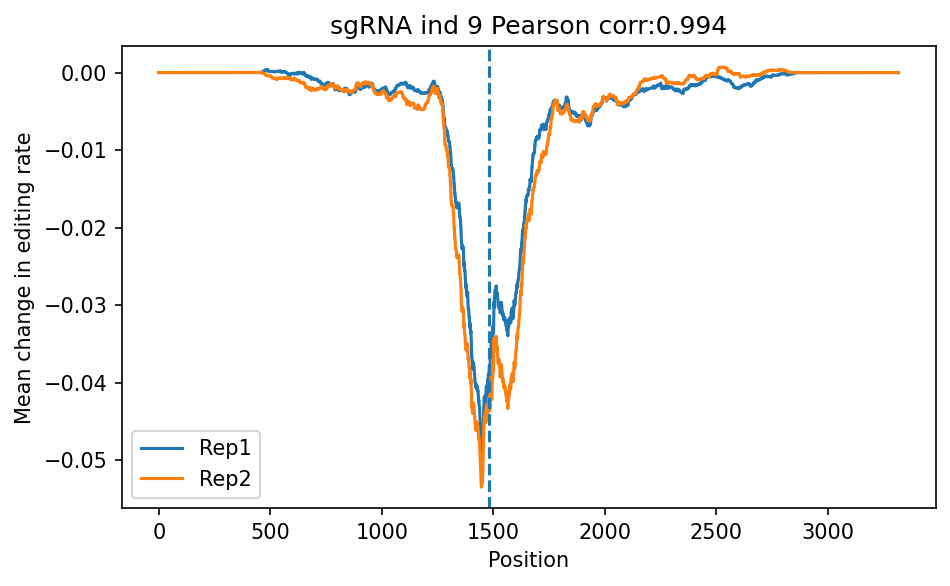

In [11]:
plt.figure(dpi=150, figsize=(7, 4))
sgRNA_ind = 9
cor = ss.pearsonr(sgRNA_effect["HJR244_1"][sgRNA_ind], sgRNA_effect["HJR244_2"][sgRNA_ind])[0]
plt.title("sgRNA ind " + str(sgRNA_ind) + " Pearson corr:" + str(round(cor, 3)))
plt.xlabel("Position")
plt.ylabel("Mean change in editing rate")
plt.plot(sgRNA_effect["HJR244_1"][sgRNA_ind], label="Rep1")
plt.plot(sgRNA_effect["HJR244_2"][sgRNA_ind], label="Rep2")
plt.axvline(x=cut_sites[sgRNA_ind], linestyle="dashed")
plt.legend()
plt.savefig(os.path.join(plot_dir, "sgRNA_diff_edit_reproducibility_sgRNA_" + str(sgRNA_ind) + ".pdf"))

### Calculate impact of CRISPR deletions on DddA footprints (first aggregating reads)

In [24]:
# Load ddda_dataset objects for both replicates
ddda_dict = {}
for replicate in ["HJR244_1", "HJR244_2"]:
    save_path = "/home/yanhu/data/DddA/HJR244/ddda_data_" + replicate + ".pkl"
    with open(save_path, "rb") as f:
        ddda_dict[replicate] = pickle.load(f)

In [13]:
# Get DddA bias for each strand
stranded_bias = {
    "C_to_T" : ddda_data.bias_dict[locus][:, 0], 
    "G_to_A" : ddda_data.bias_dict[locus][:, 1]
}

sgRNA_fp_effect = {}
footprint_radius = 50
num_reads = {}
for replicate in ["HJR244_1", "HJR244_2"]:
    ddda_data = ddda_dict[replicate]
    effect_mtx = []
    num_reads[replicate] = []
    for sgRNA_ind in range(len(cut_sites)):
        pos_num_reads = []
        diff_footprints = {}
        for strand in ["C_to_T", "G_to_A"]:

            # Retrieve read indices for CRISPR deleted and undeleted reads
            del_read_inds = sgRNA_results[replicate][sgRNA_ind][strand]["del_read_inds"]
            undel_read_inds = sgRNA_results[replicate][sgRNA_ind][strand]["undel_read_inds"]

            # Down sample del and undel reads to the same number
            # Otherwise the footprint scores can't be directly compared
            min_num = min(len(del_read_inds), len(undel_read_inds))
            del_read_inds = np.random.choice(del_read_inds, min_num, replace=False)
            undel_read_inds = np.random.choice(undel_read_inds, min_num, replace=False)
            pos_num_reads.append(min_num)
            
            # Calculate aggregate DddA edit counts
            del_edits = np.array(np.sum(ddda_data.edit_dict[locus][del_read_inds, :], axis=0))[0, :]
            undel_edits = np.array(np.sum(ddda_data.edit_dict[locus][undel_read_inds, :], axis=0))[0, :]

            # Mask CRISPR deleted region during footprinting to prevent false positive footprints
            # resulting from deletions
            del_start, del_end = cut_sites[sgRNA_ind] - 20, cut_sites[sgRNA_ind] + 20
            del_edits[del_start:del_end] = 0
            undel_edits[del_start:del_end] = 0
            bias = copy.deepcopy(stranded_bias[strand])
            bias[del_start:del_end] = 0

            # Calculate DddA footprints
            footprints_del = get_footprint_single_scale(
                del_edits, bias, 
                fp_radius=footprint_radius, combine_sides="max_pval")
            footprints_undel = get_footprint_single_scale(
                undel_edits, bias, 
                fp_radius=footprint_radius, combine_sides="max_pval")

            # Convert to -log10 pvals
            footprints_del = -np.log10(footprints_del + 1e-300)
            footprints_undel = -np.log10(footprints_undel + 1e-300)
            
            # Calculate the difference of average footprint between del and undel reads
            diff_footprints[strand] = footprints_del - footprints_undel

        mean_diff_footprints = (diff_footprints["C_to_T"] + diff_footprints["G_to_A"]) / 2
        mean_diff_footprints = np.convolve(mean_diff_footprints, np.ones(50), mode="same") / 50
        effect_mtx.append(mean_diff_footprints)
        num_reads[replicate].append(np.mean(pos_num_reads))
    
    sgRNA_fp_effect[replicate] = np.array(effect_mtx)

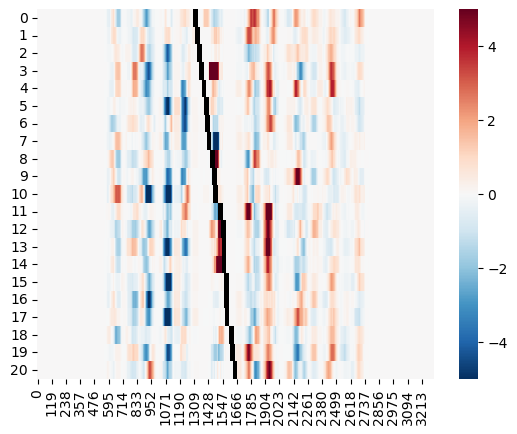

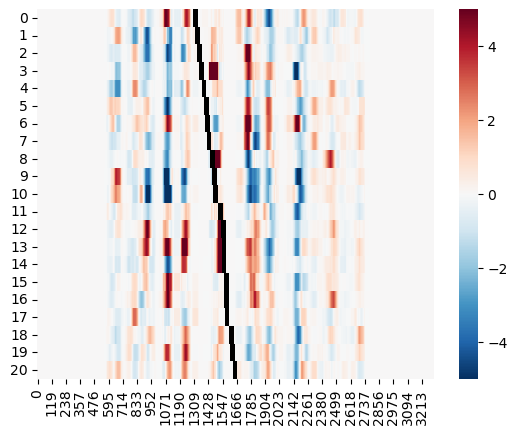

In [14]:
for replicate in ["HJR244_1", "HJR244_2"]:
    plot_dir = "/home/yanhu/data/DddA/HJR244/plots/" + replicate
    
    # Visualize base edit impact using a heatmap
    sns.heatmap(
        sgRNA_fp_effect[replicate], 
        cmap=cmap,
        mask=del_mask, vmax=5, vmin=-5)
    plt.savefig(os.path.join(plot_dir, "sgRNA_diff_fp_heatmap_" + replicate + ".png"))
    plt.show()

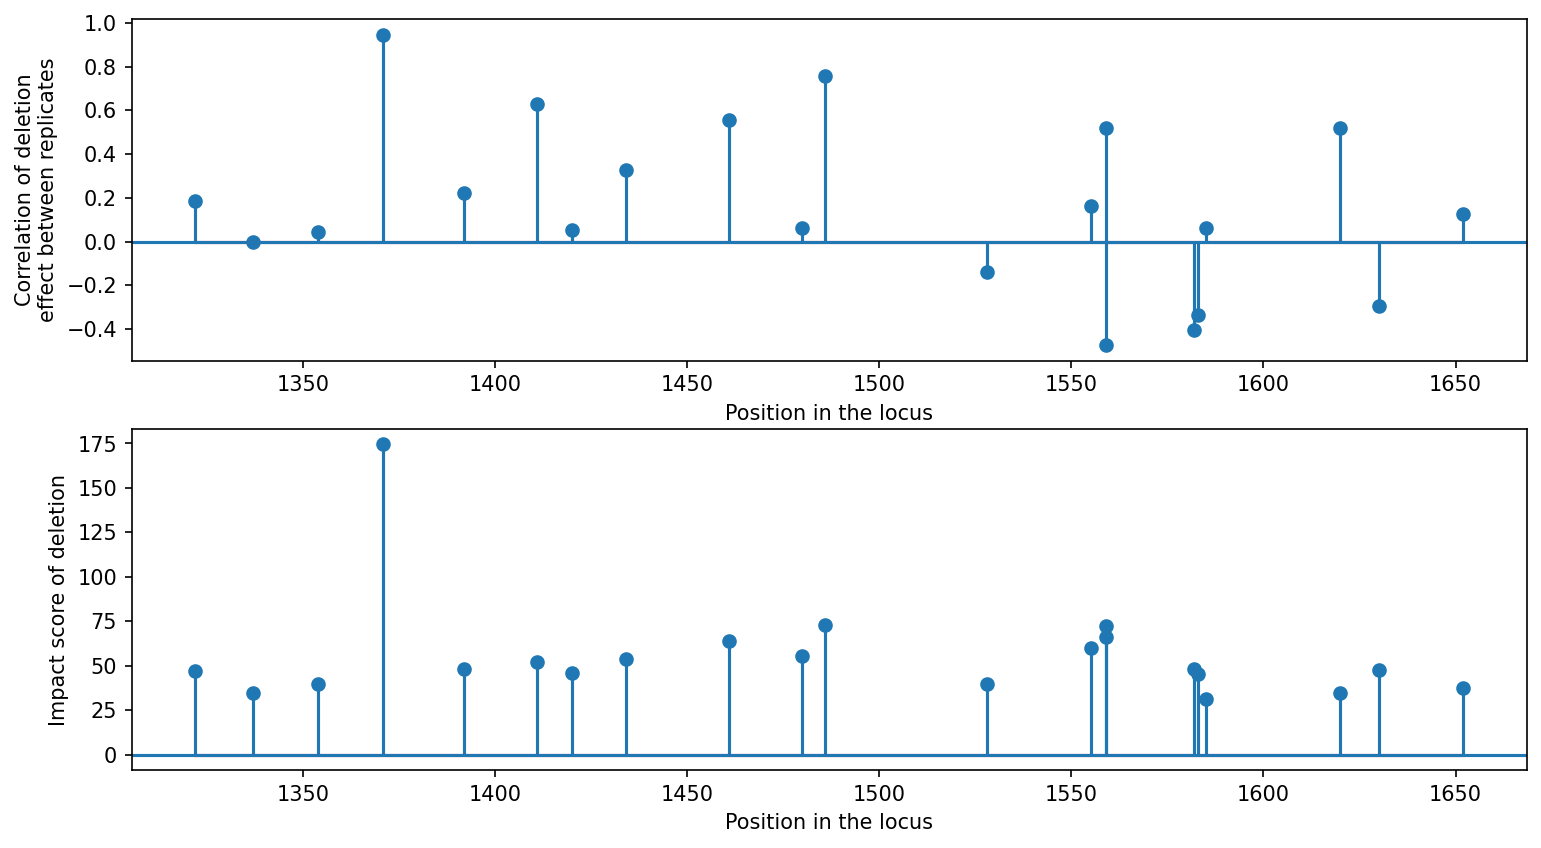

In [15]:
# Calculate correlation between replicates for each sgRNA
replicate_cor = []
for sgRNA_ind in range(len(cut_sites)):
    replicate_cor.append(ss.pearsonr(
        sgRNA_fp_effect["HJR244_1"][sgRNA_ind, :],
        sgRNA_fp_effect["HJR244_2"][sgRNA_ind, :]
    ).statistic)

# Calculate overall impact for each sgRNA
impact_score = []
for sgRNA_ind in range(len(cut_sites)):
    score_1 = np.sqrt(np.sum(np.power(sgRNA_fp_effect["HJR244_1"][sgRNA_ind, :], 2)))
    score_2 = np.sqrt(np.sum(np.power(sgRNA_fp_effect["HJR244_2"][sgRNA_ind, :], 2)))
    impact_score.append(min(score_1, score_2))

plot_dir = "/home/yanhu/data/DddA/HJR244/plots/sgRNA_diff_fp_reproducibility"
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
    
fig, ax = plt.subplots(2, 1, dpi=150, figsize=(12, 6.5))

ax[0].stem(cut_sites, replicate_cor) 
ax[0].set_ylabel("Correlation of deletion\neffect between replicates")
ax[0].set_xlabel("Position in the locus")
ax[0].axhline(y=0)

ax[1].stem(cut_sites, impact_score) 
ax[1].set_ylabel("Impact score of deletion")
ax[1].set_xlabel("Position in the locus")
#ax[1].set_ylim(0.05,0.21)
ax[1].axhline(y=0)
plt.savefig(os.path.join(plot_dir, "sgRNA_diff_fp_reproducibility.pdf"))

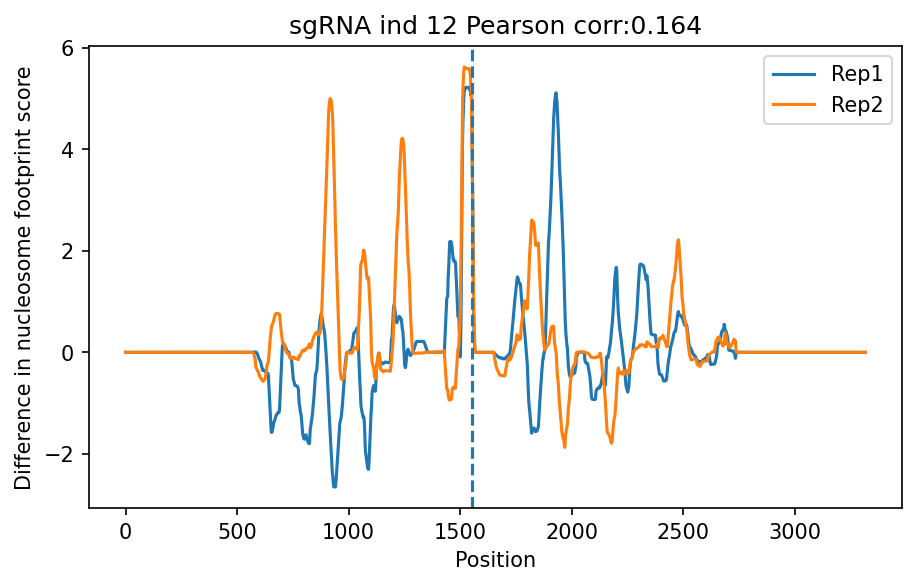

In [16]:
plot_dir = "/home/yanhu/data/DddA/HJR244/plots/sgRNA_diff_fp_reproducibility/"
plt.figure(dpi=150, figsize=(7, 4))
sgRNA_ind = 12
cor = ss.pearsonr(
    sgRNA_fp_effect["HJR244_1"][sgRNA_ind], 
    sgRNA_fp_effect["HJR244_2"][sgRNA_ind])[0]

plt.title("sgRNA ind " + str(sgRNA_ind) + " Pearson corr:" + str(round(cor, 3)))
plt.xlabel("Position")
plt.ylabel("Difference in nucleosome footprint score")
plt.plot(sgRNA_fp_effect["HJR244_1"][sgRNA_ind], label="Rep1")
plt.plot(sgRNA_fp_effect["HJR244_2"][sgRNA_ind], label="Rep2")
plt.axvline(x=cut_sites[sgRNA_ind], linestyle="dashed")
plt.legend()
plt.savefig(os.path.join(plot_dir, "sgRNA_diff_fp_reproducibility_sgRNA_" + str(sgRNA_ind) + ".pdf"))

### Calculate impact of CRISPR deletions on DddA footprints (first footprint single reads)

In [118]:
# Get DddA bias for each strand
stranded_bias = {
    "C_to_T" : ddda_data.bias_dict[locus][:, 0], 
    "G_to_A" : ddda_data.bias_dict[locus][:, 1]
}

sgRNA_fp_effect = {}
footprint_radii = [50]
num_reads = {}
footprint_dict = {}
for replicate in ["HJR244_1", "HJR244_2"]:
    ddda_data = ddda_dict[replicate]
    effect_mtx = []
    num_reads[replicate] = []
    footprint_dict[replicate] = {}
    for sgRNA_ind in range(len(cut_sites)):
        pos_num_reads = []
        diff_footprints = {}
        footprint_dict[replicate][sgRNA_ind] = {}
        for strand in ["C_to_T", "G_to_A"]:
            footprint_dict[replicate][sgRNA_ind][strand] = {}
            for read_group in ["del", "undel"]:

                # Retrieve read indices
                read_inds = sgRNA_results[replicate][sgRNA_ind][strand][read_group + "_read_inds"]

                # Calculate footprints
                footprints_dict = ddda_data.get_footprints(
                    {locus:np.array(ddda_data.read_ids[locus])[read_inds]}, 
                    footprint_radii = [50], 
                    combine_sides="max_pval")
                footprints = np.squeeze(np.array([i for i in footprints_dict[locus].values()]))
                footprints = -np.log10(footprints + 1e-300)
                footprints = np.mean(footprints, axis=0)
                footprint_dict[replicate][sgRNA_ind][strand][read_group] = footprints
                
            # Calculate the difference of average footprint between del and undel reads
            grouped_footprints = footprint_dict[replicate][sgRNA_ind][strand]
            diff_footprints[strand] = grouped_footprints["del"] - grouped_footprints["undel"]
        mean_diff_footprints = (diff_footprints["C_to_T"] + diff_footprints["G_to_A"]) / 2
        mean_diff_footprints = np.convolve(mean_diff_footprints, np.ones(50), mode="same") / 50
        effect_mtx.append(mean_diff_footprints)
        num_reads[replicate].append(np.mean(pos_num_reads))
    
    sgRNA_fp_effect[replicate] = np.array(effect_mtx)

with open("/home/yanhu/data/DddA/HJR244/sgRNA_fp_effect_single_read.pkl", "wb") as f:
    pickle.dump(sgRNA_fp_effect, f)

Computing footprints for HJR244


100%|███████████████████████████████████████████████████████████████████████| 526/526 [00:05<00:00, 105.03it/s]


Computing footprints for HJR244


100%|█████████████████████████████████████████████████████████████████████| 1264/1264 [00:11<00:00, 109.44it/s]


Computing footprints for HJR244


100%|███████████████████████████████████████████████████████████████████████| 744/744 [00:06<00:00, 110.36it/s]


Computing footprints for HJR244


100%|█████████████████████████████████████████████████████████████████████| 1745/1745 [00:15<00:00, 111.50it/s]
/home/yanhu/utils/miniforge3/envs/DddA/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yanhu/utils/miniforge3/envs/DddA/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Computing footprints for HJR244


100%|███████████████████████████████████████████████████████████████████████| 444/444 [00:04<00:00, 103.62it/s]


Computing footprints for HJR244


100%|███████████████████████████████████████████████████████████████████████| 785/785 [00:07<00:00, 104.74it/s]


Computing footprints for HJR244


100%|███████████████████████████████████████████████████████████████████████| 556/556 [00:05<00:00, 104.04it/s]


Computing footprints for HJR244


100%|█████████████████████████████████████████████████████████████████████| 1139/1139 [00:10<00:00, 106.11it/s]


Computing footprints for HJR244


100%|███████████████████████████████████████████████████████████████████████| 467/467 [00:04<00:00, 101.75it/s]


Computing footprints for HJR244


100%|█████████████████████████████████████████████████████████████████████| 1545/1545 [00:14<00:00, 106.31it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 728/728 [00:07<00:00, 99.98it/s]


Computing footprints for HJR244


100%|█████████████████████████████████████████████████████████████████████| 2191/2191 [00:21<00:00, 101.78it/s]


Computing footprints for HJR244


100%|█████████████████████████████████████████████████████████████████████| 1946/1946 [00:17<00:00, 111.98it/s]


Computing footprints for HJR244


100%|█████████████████████████████████████████████████████████████████████| 1524/1524 [00:14<00:00, 107.18it/s]


Computing footprints for HJR244


100%|███████████████████████████████████████████████████████████████████████| 569/569 [00:05<00:00, 107.14it/s]


Computing footprints for HJR244


100%|█████████████████████████████████████████████████████████████████████| 2192/2192 [00:20<00:00, 109.21it/s]


Computing footprints for HJR244


100%|█████████████████████████████████████████████████████████████████████| 2177/2177 [00:20<00:00, 107.93it/s]


Computing footprints for HJR244


100%|█████████████████████████████████████████████████████████████████████| 1586/1586 [00:14<00:00, 108.16it/s]


Computing footprints for HJR244


100%|█████████████████████████████████████████████████████████████████████| 1028/1028 [00:09<00:00, 105.02it/s]


Computing footprints for HJR244


100%|█████████████████████████████████████████████████████████████████████| 2156/2156 [00:20<00:00, 107.59it/s]


Computing footprints for HJR244


100%|███████████████████████████████████████████████████████████████████████| 688/688 [00:06<00:00, 102.56it/s]


Computing footprints for HJR244


100%|█████████████████████████████████████████████████████████████████████| 1536/1536 [00:14<00:00, 106.38it/s]


Computing footprints for HJR244


100%|███████████████████████████████████████████████████████████████████████| 927/927 [00:08<00:00, 106.26it/s]


Computing footprints for HJR244


100%|█████████████████████████████████████████████████████████████████████| 2183/2183 [00:20<00:00, 107.05it/s]


Computing footprints for HJR244


100%|███████████████████████████████████████████████████████████████████████| 670/670 [00:06<00:00, 109.45it/s]


Computing footprints for HJR244


100%|█████████████████████████████████████████████████████████████████████| 1562/1562 [00:14<00:00, 107.44it/s]


Computing footprints for HJR244


100%|███████████████████████████████████████████████████████████████████████| 913/913 [00:08<00:00, 108.01it/s]


Computing footprints for HJR244


100%|█████████████████████████████████████████████████████████████████████| 2163/2163 [00:19<00:00, 109.18it/s]


Computing footprints for HJR244


100%|███████████████████████████████████████████████████████████████████████| 603/603 [00:05<00:00, 108.15it/s]


Computing footprints for HJR244


100%|█████████████████████████████████████████████████████████████████████| 1529/1529 [00:14<00:00, 106.54it/s]


Computing footprints for HJR244


100%|███████████████████████████████████████████████████████████████████████| 887/887 [00:08<00:00, 106.28it/s]


Computing footprints for HJR244


100%|█████████████████████████████████████████████████████████████████████| 2171/2171 [00:20<00:00, 107.05it/s]


Computing footprints for HJR244


100%|███████████████████████████████████████████████████████████████████████| 630/630 [00:06<00:00, 103.05it/s]


Computing footprints for HJR244


100%|█████████████████████████████████████████████████████████████████████| 1540/1540 [00:14<00:00, 106.02it/s]


Computing footprints for HJR244


100%|███████████████████████████████████████████████████████████████████████| 865/865 [00:08<00:00, 105.60it/s]


Computing footprints for HJR244


100%|█████████████████████████████████████████████████████████████████████| 2154/2154 [00:20<00:00, 106.45it/s]


Computing footprints for HJR244


100%|███████████████████████████████████████████████████████████████████████| 927/927 [00:08<00:00, 109.24it/s]


Computing footprints for HJR244


100%|█████████████████████████████████████████████████████████████████████| 1576/1576 [00:15<00:00, 104.42it/s]


Computing footprints for HJR244


100%|█████████████████████████████████████████████████████████████████████| 1018/1018 [00:09<00:00, 111.21it/s]


Computing footprints for HJR244


100%|█████████████████████████████████████████████████████████████████████| 2191/2191 [00:20<00:00, 106.88it/s]


Computing footprints for HJR244


100%|███████████████████████████████████████████████████████████████████████| 922/922 [00:08<00:00, 113.71it/s]


Computing footprints for HJR244


100%|█████████████████████████████████████████████████████████████████████| 1600/1600 [00:15<00:00, 106.10it/s]


Computing footprints for HJR244


100%|█████████████████████████████████████████████████████████████████████| 1075/1075 [00:09<00:00, 112.13it/s]


Computing footprints for HJR244


100%|█████████████████████████████████████████████████████████████████████| 2132/2132 [00:19<00:00, 107.55it/s]


Computing footprints for HJR244


100%|███████████████████████████████████████████████████████████████████████| 626/626 [00:06<00:00, 101.46it/s]


Computing footprints for HJR244


100%|█████████████████████████████████████████████████████████████████████| 1528/1528 [00:14<00:00, 107.48it/s]


Computing footprints for HJR244


100%|███████████████████████████████████████████████████████████████████████| 774/774 [00:07<00:00, 103.92it/s]


Computing footprints for HJR244


100%|█████████████████████████████████████████████████████████████████████| 2191/2191 [00:19<00:00, 109.99it/s]


Computing footprints for HJR244


100%|███████████████████████████████████████████████████████████████████████| 896/896 [00:08<00:00, 111.08it/s]


Computing footprints for HJR244


100%|█████████████████████████████████████████████████████████████████████| 1594/1594 [00:14<00:00, 112.25it/s]


Computing footprints for HJR244


100%|█████████████████████████████████████████████████████████████████████| 1077/1077 [00:09<00:00, 110.19it/s]


Computing footprints for HJR244


100%|█████████████████████████████████████████████████████████████████████| 2138/2138 [00:18<00:00, 112.87it/s]


Computing footprints for HJR244


100%|███████████████████████████████████████████████████████████████████████| 897/897 [00:07<00:00, 113.52it/s]


Computing footprints for HJR244


100%|█████████████████████████████████████████████████████████████████████| 1568/1568 [00:13<00:00, 113.92it/s]


Computing footprints for HJR244


100%|█████████████████████████████████████████████████████████████████████| 1097/1097 [00:10<00:00, 106.78it/s]


Computing footprints for HJR244


100%|█████████████████████████████████████████████████████████████████████| 2142/2142 [00:18<00:00, 113.56it/s]


Computing footprints for HJR244


100%|███████████████████████████████████████████████████████████████████████| 873/873 [00:07<00:00, 112.91it/s]


Computing footprints for HJR244


100%|█████████████████████████████████████████████████████████████████████| 1577/1577 [00:14<00:00, 111.55it/s]


Computing footprints for HJR244


100%|█████████████████████████████████████████████████████████████████████| 1127/1127 [00:10<00:00, 111.61it/s]


Computing footprints for HJR244


100%|█████████████████████████████████████████████████████████████████████| 2093/2093 [00:19<00:00, 109.46it/s]


Computing footprints for HJR244


100%|███████████████████████████████████████████████████████████████████████| 648/648 [00:05<00:00, 112.81it/s]


Computing footprints for HJR244


100%|█████████████████████████████████████████████████████████████████████| 1535/1535 [00:13<00:00, 113.80it/s]


Computing footprints for HJR244


100%|█████████████████████████████████████████████████████████████████████| 1066/1066 [00:09<00:00, 112.24it/s]


Computing footprints for HJR244


100%|█████████████████████████████████████████████████████████████████████| 2176/2176 [00:19<00:00, 109.07it/s]


Computing footprints for HJR244


100%|███████████████████████████████████████████████████████████████████████| 657/657 [00:06<00:00, 100.44it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 1568/1568 [00:15<00:00, 99.56it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 872/872 [00:08<00:00, 99.18it/s]


Computing footprints for HJR244


100%|█████████████████████████████████████████████████████████████████████| 2151/2151 [00:19<00:00, 109.83it/s]


Computing footprints for HJR244


100%|███████████████████████████████████████████████████████████████████████| 682/682 [00:05<00:00, 115.63it/s]


Computing footprints for HJR244


100%|█████████████████████████████████████████████████████████████████████| 1570/1570 [00:14<00:00, 111.45it/s]


Computing footprints for HJR244


100%|███████████████████████████████████████████████████████████████████████| 881/881 [00:08<00:00, 107.65it/s]


Computing footprints for HJR244


100%|█████████████████████████████████████████████████████████████████████| 2139/2139 [00:18<00:00, 112.72it/s]


Computing footprints for HJR244


100%|███████████████████████████████████████████████████████████████████████| 784/784 [00:07<00:00, 107.85it/s]


Computing footprints for HJR244


100%|█████████████████████████████████████████████████████████████████████| 1524/1524 [00:13<00:00, 111.82it/s]


Computing footprints for HJR244


100%|███████████████████████████████████████████████████████████████████████| 776/776 [00:06<00:00, 114.52it/s]


Computing footprints for HJR244


100%|█████████████████████████████████████████████████████████████████████| 2186/2186 [00:19<00:00, 114.30it/s]


Computing footprints for HJR244


100%|███████████████████████████████████████████████████████████████████████| 806/806 [00:06<00:00, 115.82it/s]


Computing footprints for HJR244


100%|█████████████████████████████████████████████████████████████████████| 1599/1599 [00:14<00:00, 111.12it/s]


Computing footprints for HJR244


100%|███████████████████████████████████████████████████████████████████████| 764/764 [00:06<00:00, 116.85it/s]


Computing footprints for HJR244


100%|█████████████████████████████████████████████████████████████████████| 2129/2129 [00:18<00:00, 113.87it/s]


Computing footprints for HJR244


100%|███████████████████████████████████████████████████████████████████████| 531/531 [00:04<00:00, 113.72it/s]


Computing footprints for HJR244


100%|█████████████████████████████████████████████████████████████████████| 1568/1568 [00:14<00:00, 107.31it/s]


Computing footprints for HJR244


100%|███████████████████████████████████████████████████████████████████████| 742/742 [00:07<00:00, 100.81it/s]


Computing footprints for HJR244


100%|█████████████████████████████████████████████████████████████████████| 2166/2166 [00:21<00:00, 101.21it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 609/609 [00:09<00:00, 63.28it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 1532/1532 [00:23<00:00, 64.48it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 841/841 [00:13<00:00, 62.02it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 2063/2063 [00:32<00:00, 62.79it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 709/709 [00:11<00:00, 63.04it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 1500/1500 [00:24<00:00, 61.98it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 918/918 [00:14<00:00, 64.67it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 2029/2029 [00:32<00:00, 61.62it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 536/536 [00:08<00:00, 59.76it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 1536/1536 [00:25<00:00, 60.62it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 699/699 [00:11<00:00, 60.72it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 2012/2012 [00:31<00:00, 63.02it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 1872/1872 [00:30<00:00, 61.10it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 1504/1504 [00:23<00:00, 62.98it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 558/558 [00:08<00:00, 62.74it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 2054/2054 [00:32<00:00, 63.01it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 2139/2139 [00:34<00:00, 62.45it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 1524/1524 [00:24<00:00, 62.31it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 1013/1013 [00:16<00:00, 63.21it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 2049/2049 [00:32<00:00, 63.37it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 589/589 [00:09<00:00, 62.79it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 1573/1573 [00:24<00:00, 62.93it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 870/870 [00:13<00:00, 62.34it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 2042/2042 [00:35<00:00, 58.11it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 587/587 [00:09<00:00, 60.51it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 1532/1532 [00:23<00:00, 65.14it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 831/831 [00:12<00:00, 64.03it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 2027/2027 [00:30<00:00, 65.88it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 643/643 [00:09<00:00, 67.39it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 1532/1532 [00:23<00:00, 65.48it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 827/827 [00:12<00:00, 64.23it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 2036/2036 [00:30<00:00, 66.65it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 709/709 [00:10<00:00, 66.55it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 1514/1514 [00:23<00:00, 63.88it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 770/770 [00:12<00:00, 64.07it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 2044/2044 [00:31<00:00, 65.50it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 805/805 [00:12<00:00, 65.37it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 1528/1528 [00:23<00:00, 65.72it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 993/993 [00:16<00:00, 60.36it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 2027/2027 [00:33<00:00, 61.03it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 885/885 [00:14<00:00, 59.87it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 1537/1537 [00:25<00:00, 61.13it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 1005/1005 [00:16<00:00, 60.94it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 2064/2064 [00:31<00:00, 64.54it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 610/610 [00:10<00:00, 60.54it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 1566/1566 [00:25<00:00, 62.52it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 731/731 [00:11<00:00, 63.08it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 2038/2038 [00:32<00:00, 62.96it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 838/838 [00:13<00:00, 60.68it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 1561/1561 [00:25<00:00, 61.66it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 1094/1094 [00:18<00:00, 58.89it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 2048/2048 [00:33<00:00, 61.27it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 845/845 [00:14<00:00, 59.91it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 1536/1536 [00:25<00:00, 60.67it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 1043/1043 [00:18<00:00, 57.11it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 2041/2041 [00:33<00:00, 60.16it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 803/803 [00:13<00:00, 58.56it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 1520/1520 [00:24<00:00, 62.53it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 1072/1072 [00:17<00:00, 60.64it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 2033/2033 [00:32<00:00, 61.96it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 655/655 [00:10<00:00, 60.43it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 1488/1488 [00:23<00:00, 62.27it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 1025/1025 [00:16<00:00, 60.46it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 2068/2068 [00:34<00:00, 60.19it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 696/696 [00:12<00:00, 56.99it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 1516/1516 [00:24<00:00, 61.14it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 770/770 [00:12<00:00, 63.29it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 2050/2050 [00:32<00:00, 63.72it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 655/655 [00:10<00:00, 60.91it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 1570/1570 [00:25<00:00, 61.91it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 812/812 [00:12<00:00, 62.90it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 2048/2048 [00:34<00:00, 59.05it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 745/745 [00:12<00:00, 59.60it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 1506/1506 [00:25<00:00, 59.96it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 756/756 [00:12<00:00, 60.37it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 2106/2106 [00:34<00:00, 61.06it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 773/773 [00:12<00:00, 60.89it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 1567/1567 [00:25<00:00, 61.67it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 728/728 [00:12<00:00, 59.79it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 2046/2046 [00:33<00:00, 61.11it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 565/565 [00:09<00:00, 60.41it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 1519/1519 [00:24<00:00, 61.00it/s]


Computing footprints for HJR244


100%|████████████████████████████████████████████████████████████████████████| 736/736 [00:12<00:00, 60.60it/s]


Computing footprints for HJR244


100%|██████████████████████████████████████████████████████████████████████| 2065/2065 [00:33<00:00, 60.87it/s]


In [12]:
with open("/home/yanhu/data/DddA/HJR244/sgRNA_fp_effect_single_read.pkl", "rb") as f:
    sgRNA_fp_effect = pickle.load(f)

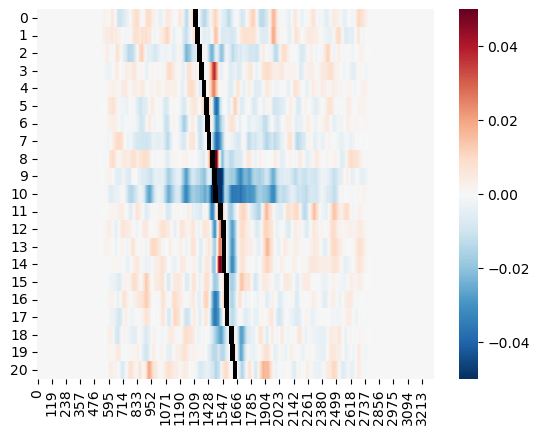

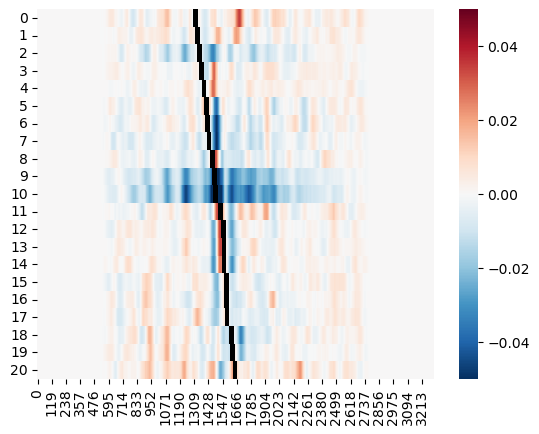

In [14]:
for replicate in ["HJR244_1", "HJR244_2"]:
    plot_dir = "/home/yanhu/data/DddA/HJR244/plots/" + replicate
    
    # Visualize footprint impact using a heatmap
    import matplotlib as mpl
    cmap = mpl.colormaps.get_cmap('RdBu_r')
    cmap.set_bad("k")
    ax = sns.heatmap(
        sgRNA_fp_effect[replicate], 
        cmap=cmap,
        mask=del_mask, vmin=-0.05, vmax=0.05)
    ax.collections[0].set_rasterized(True)
    plt.savefig(os.path.join(plot_dir, "sgRNA_diff_single_read_fp_heatmap_" + replicate + ".pdf"))
    plt.show()

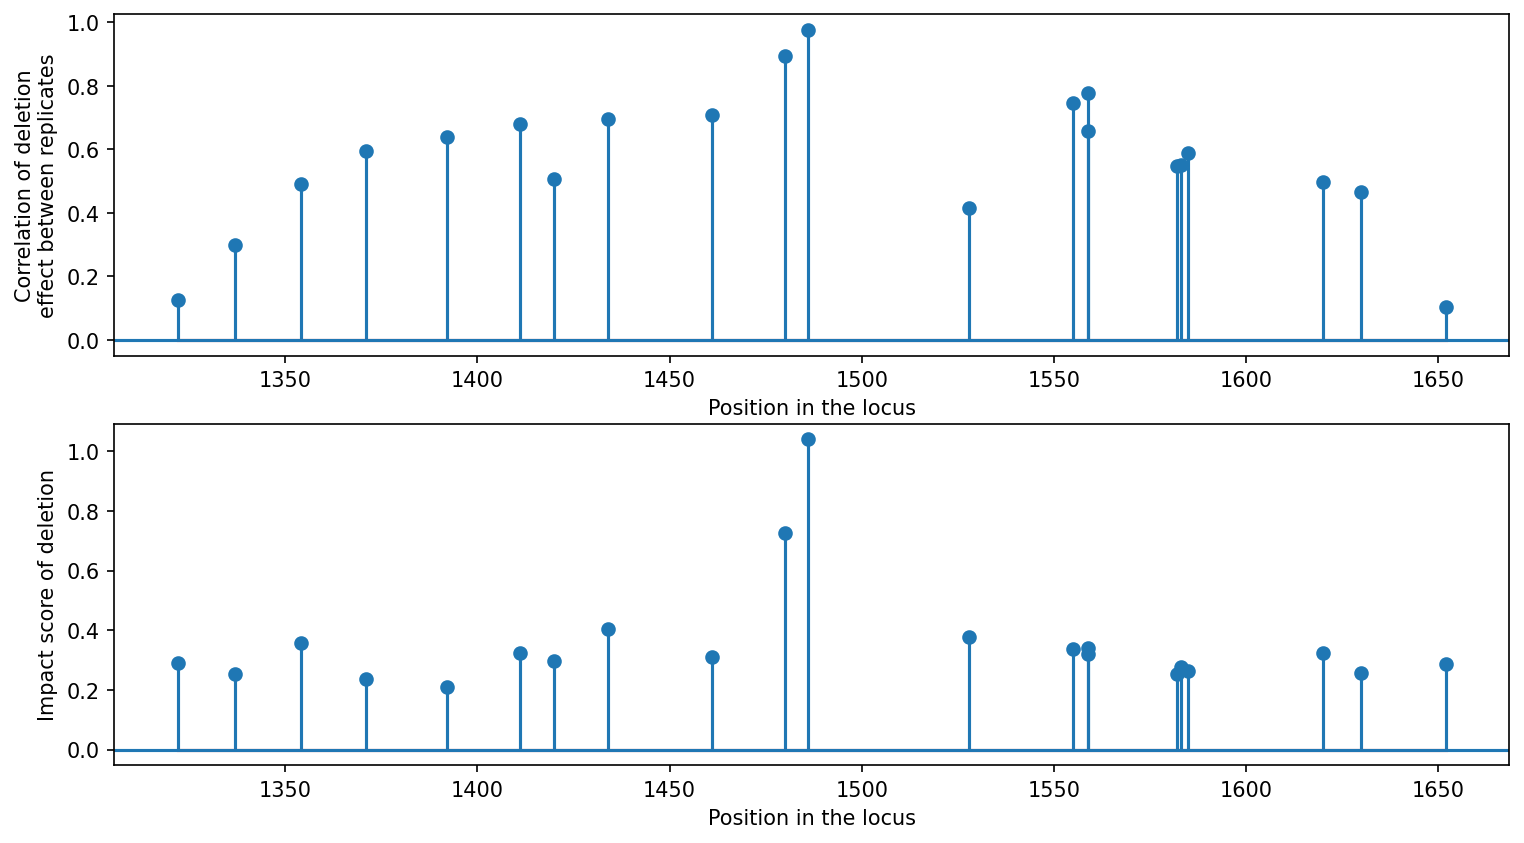

In [20]:
# Calculate correlation between replicates for each sgRNA
replicate_cor = []
for sgRNA_ind in range(len(cut_sites)):
    replicate_cor.append(ss.pearsonr(
        sgRNA_fp_effect["HJR244_1"][sgRNA_ind, :],
        sgRNA_fp_effect["HJR244_2"][sgRNA_ind, :]
    ).statistic)

# Calculate overall impact for each sgRNA
impact_score = []
for sgRNA_ind in range(len(cut_sites)):
    score_1 = np.sqrt(np.sum(np.power(sgRNA_fp_effect["HJR244_1"][sgRNA_ind, :], 2)))
    score_2 = np.sqrt(np.sum(np.power(sgRNA_fp_effect["HJR244_2"][sgRNA_ind, :], 2)))
    impact_score.append(min(score_1, score_2))

plot_dir = "/home/yanhu/data/DddA/HJR244/plots/sgRNA_diff_fp_reproducibility"
fig, ax = plt.subplots(2, 1, dpi=150, figsize=(12, 6.5))

ax[0].stem(cut_sites, replicate_cor) 
ax[0].set_ylabel("Correlation of deletion\neffect between replicates")
ax[0].set_xlabel("Position in the locus")
ax[0].axhline(y=0)

ax[1].stem(cut_sites, impact_score) 
ax[1].set_ylabel("Impact score of deletion")
ax[1].set_xlabel("Position in the locus")
#ax[1].set_ylim(0.05,0.21)
ax[1].axhline(y=0)
plt.savefig(os.path.join(plot_dir, "sgRNA_diff_single_read_fp_reproducibility.pdf"))

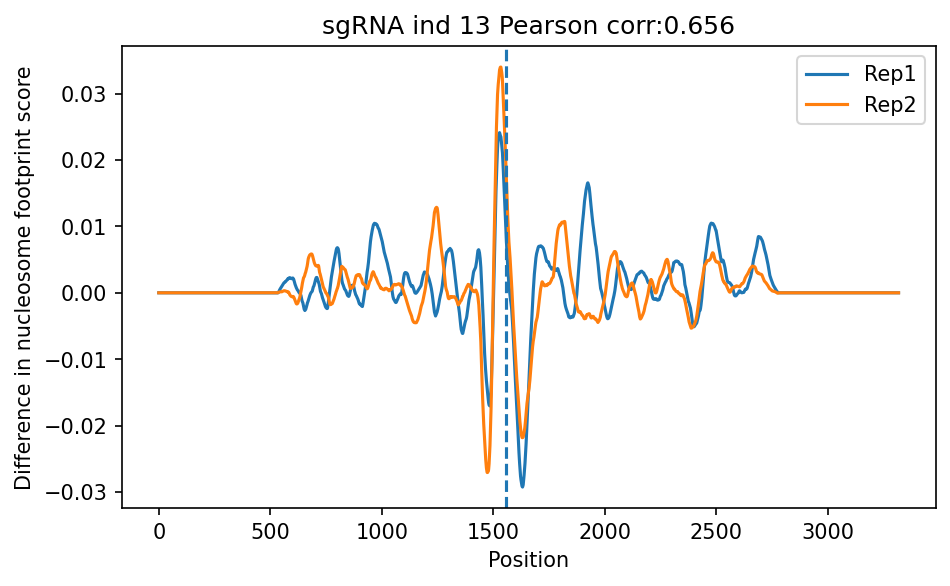

In [21]:
plot_dir = "/home/yanhu/data/DddA/HJR244/plots/sgRNA_diff_fp_reproducibility"
plt.figure(dpi=150, figsize=(7, 4))
sgRNA_ind = 13
cor = ss.pearsonr(
    sgRNA_fp_effect["HJR244_1"][sgRNA_ind], 
    sgRNA_fp_effect["HJR244_2"][sgRNA_ind])[0]

plt.title("sgRNA ind " + str(sgRNA_ind) + " Pearson corr:" + str(round(cor, 3)))
plt.xlabel("Position")
plt.ylabel("Difference in nucleosome footprint score")
plt.plot(sgRNA_fp_effect["HJR244_1"][sgRNA_ind], label="Rep1")
plt.plot(sgRNA_fp_effect["HJR244_2"][sgRNA_ind], label="Rep2")
plt.axvline(x=cut_sites[sgRNA_ind], linestyle="dashed")
plt.legend()
plt.savefig(os.path.join(plot_dir, "sgRNA_diff_single_read_fp_reproducibility_sgRNA_" + str(sgRNA_ind) + ".pdf"))